In [36]:
import tensorflow as tf
import os
import cv2
import numpy as np

In [37]:
!kaggle datasets download -d kunalmadan/vehicle-multi-classification

vehicle-multi-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [38]:
from zipfile import ZipFile

zip_file_path = '/content/data.zip'

with ZipFile(zip_file_path, 'r') as zip:
    zip.extractall()

In [39]:
data_dir = 'data' 

In [40]:
extensions = ('.png', '.jpg', '.jpeg')

In [41]:
valid_images = []  

for image_class in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, image_class)
    if not os.path.isdir(class_dir):
        continue
    for image in os.listdir(class_dir):
        if image.lower().endswith(extensions):
            image_path = os.path.join(class_dir, image)
            img = cv2.imread(image_path)
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            
            valid_images.append((img, image_class))
        else:
            print('Issue with image {}'.format(image_path))

Issue with image data/car/images238.jpg
Issue with image data/car/se-image-2180c3d181555154d1bc13ffbbf05f29.jpg
Issue with image data/car/images166.jpg
Issue with image data/car/images174.jpg
Issue with image data/car/images41.jpg
Issue with image data/car/images17.jpg
Issue with image data/car/images17.jpg
Issue with image data/car/images28.jpg
Issue with image data/car/images65.jpg
Issue with image data/car/images65.jpg
Issue with image data/car/gate_models_s_02.jpg
Issue with image data/car/images184.jpg
Issue with image data/car/red-premium-business-sedan-car-sports-configuration-white-background-3d-rendering_101266-26555.jpg
Issue with image data/car/red-premium-business-sedan-car-sports-configuration-white-background-3d-rendering_101266-26555.jpg
Issue with image data/car/Cover-How-to-draw-a-car.png
Issue with image data/car/images45.jpg
Issue with image data/car/images199.jpg


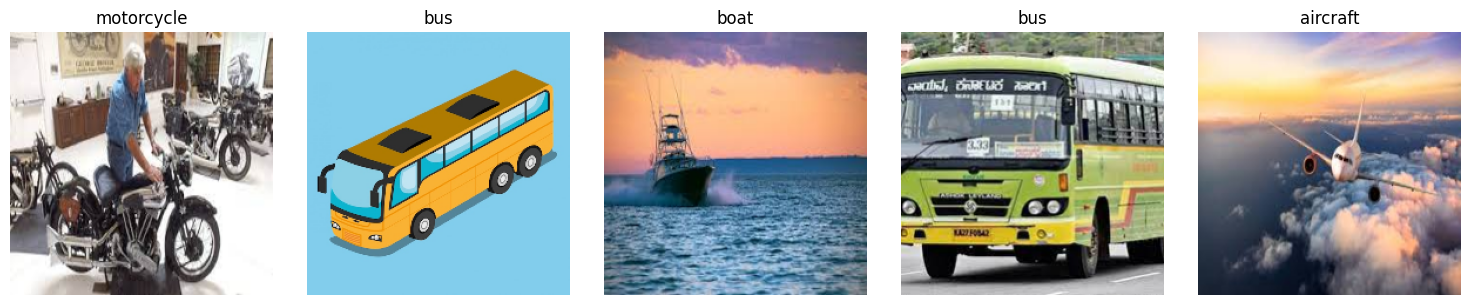

In [42]:
import matplotlib.pyplot as plt
import random

random_images = random.sample(valid_images, 5)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, (image, image_class) in enumerate(random_images):
    axes[i].imshow(image)
    axes[i].set_title(image_class)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [43]:
files = os.listdir(data_dir)
print(files)

['aircraft', 'bus', 'truck', 'motorcycle', 'boat', 'car']


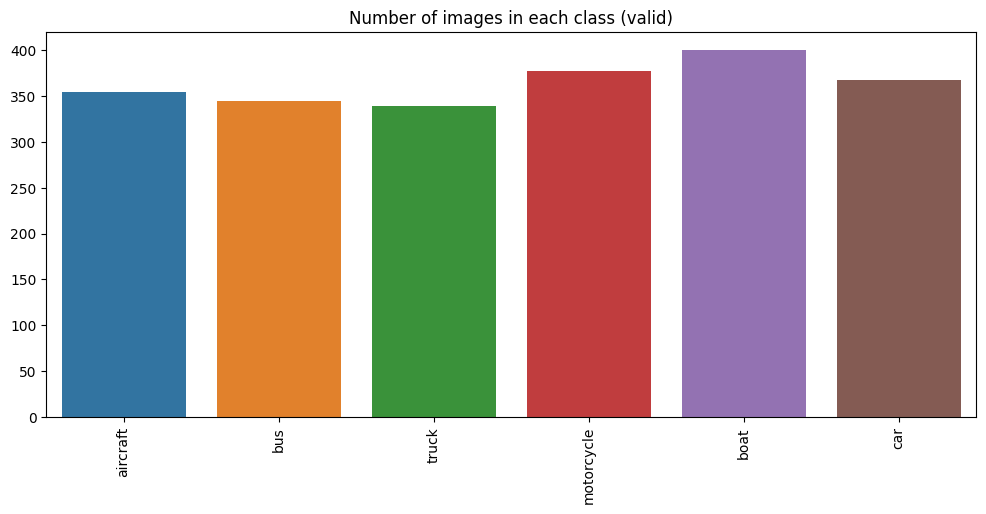

In [44]:
import seaborn as sns

classes = []
num_imgs = []

for _, image_class in valid_images:
    if image_class not in classes:
        classes.append(image_class)
        num_imgs.append(1)
    else:
        index = classes.index(image_class)
        num_imgs[index] += 1

plt.figure(figsize=(12, 5))
sns.barplot(x=classes, y=num_imgs)
plt.title('Number of images in each class (valid)')
plt.xticks(rotation=90)
plt.show()


In [45]:
from sklearn.model_selection import train_test_split

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

train_data, remaining_data = train_test_split(valid_images, test_size=1 - train_ratio, random_state=42)
val_data, test_data = train_test_split(remaining_data, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)

In [46]:
print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))

Training set size: 1527
Validation set size: 436
Test set size: 219


In [47]:
train_images = np.array([data[0] for data in train_data])
train_labels = np.array([data[1] for data in train_data])
val_images = np.array([data[0] for data in val_data])
val_labels = np.array([data[1] for data in val_data])
test_images = np.array([data[0] for data in test_data])
test_labels = np.array([data[1] for data in test_data])

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [49]:
label_map = {
    "aircraft": 0,
    "boat": 1,
    "bus": 2,
    "car": 3,
    "motorcycle": 4,
    "truck": 5
}

In [50]:
train_labels = [label_map[class_name] for (_, class_name) in train_data]
val_labels = [label_map[class_name] for (_, class_name) in val_data]
test_labels = [label_map[class_name] for (_, class_name) in test_data]

In [51]:
from tensorflow.keras.utils import to_categorical
num_classes = len(classes)

train_labels = to_categorical(train_labels, num_classes)
val_labels = to_categorical(val_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [52]:
batch_size = 32

In [53]:
train_generator = train_datagen.flow(
    train_images,
    train_labels,
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow(
    val_images,
    val_labels,
    batch_size=batch_size
)

test_generator = test_datagen.flow(
    test_images,
    test_labels,
    batch_size=batch_size
)

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])

In [55]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
48/48 [==============================] - 23s 434ms/step - loss: 1.8576 - accuracy: 0.1775 - val_loss: 1.7911 - val_accuracy: 0.1766
Epoch 2/10
48/48 [==============================] - 21s 436ms/step - loss: 1.7906 - accuracy: 0.1840 - val_loss: 1.7920 - val_accuracy: 0.1766
Epoch 3/10
48/48 [==============================] - 20s 420ms/step - loss: 1.7902 - accuracy: 0.1840 - val_loss: 1.7922 - val_accuracy: 0.1766
Epoch 4/10
48/48 [==============================] - 20s 418ms/step - loss: 1.7901 - accuracy: 0.1840 - val_loss: 1.7931 - val_accuracy: 0.1766
Epoch 5/10
48/48 [==============================] - 21s 432ms/step - loss: 1.7900 - accuracy: 0.1840 - val_loss: 1.7939 - val_accuracy: 0.1766
Epoch 6/10
48/48 [==============================] - 20s 417ms/step - loss: 1.7896 - accuracy: 0.1840 - val_loss: 1.7936 - val_accuracy: 0.1766
Epoch 7/10
48/48 [==============================] - 21s 433ms/step - loss: 1.7897 - accuracy: 0.1840 - val_loss: 1.7937 - val_accuracy: 0.1766

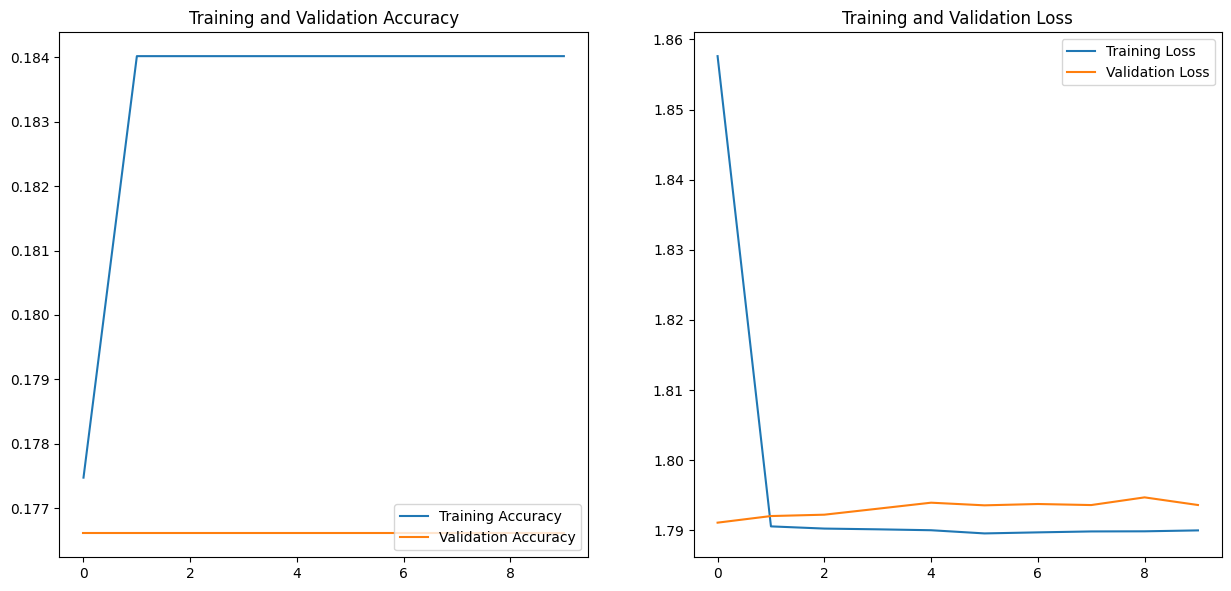

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [57]:
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test accuracy:', test_accuracy)

7/7 [==============================] - 1s 134ms/step - loss: 1.7906 - accuracy: 0.1918
Test accuracy: 0.19178082048892975


In [58]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

last_output = base_model.output

x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


87910968/87910968 [==============================] - 0s 0us/step


In [59]:
from keras.callbacks import EarlyStopping,LearningRateScheduler, ModelCheckpoint
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 3, verbose = 1, restore_best_weights=True)

In [60]:
epochs = 10

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    callbacks=[checkpoint,earlystopping])

Epoch 1/10
48/48 [==============================] - ETA: 0s - loss: 1.1412 - accuracy: 0.5900
Epoch 1: val_loss improved from inf to 0.42580, saving model to model.h5
48/48 [==============================] - 32s 505ms/step - loss: 1.1412 - accuracy: 0.5900 - val_loss: 0.4258 - val_accuracy: 0.9151
Epoch 2/10
48/48 [==============================] - ETA: 0s - loss: 0.6106 - accuracy: 0.8088
Epoch 2: val_loss improved from 0.42580 to 0.29881, saving model to model.h5
48/48 [==============================] - 20s 419ms/step - loss: 0.6106 - accuracy: 0.8088 - val_loss: 0.2988 - val_accuracy: 0.9266
Epoch 3/10
48/48 [==============================] - ETA: 0s - loss: 0.5611 - accuracy: 0.8107
Epoch 3: val_loss improved from 0.29881 to 0.28212, saving model to model.h5
48/48 [==============================] - 21s 441ms/step - loss: 0.5611 - accuracy: 0.8107 - val_loss: 0.2821 - val_accuracy: 0.9197
Epoch 4/10
48/48 [==============================] - ETA: 0s - loss: 0.4519 - accuracy: 0.8520
E

In [61]:
best_model=tf.keras.models.load_model('model.h5')

In [62]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [63]:
test_loss, test_acc = best_model.evaluate(test_generator)
print('Test accuracy:', test_acc)

7/7 [==============================] - 3s 332ms/step - loss: 0.1999 - accuracy: 0.9406
Test accuracy: 0.9406392574310303


In [64]:
from sklearn.metrics import classification_report

class_names = {v: k for k, v in label_map.items()}

test_pred_labels = best_model.predict(test_generator)
test_pred_labels = np.argmax(test_pred_labels,axis=1)
test_pred_class_names = [class_names[i] for i in test_pred_labels]
true_class_names = [class_names[i] for i in np.argmax(test_labels, axis=1)]

report = classification_report(true_class_names, test_pred_class_names)

print("Classification Report:")
print(report)


7/7 [==============================] - 2s 76ms/step
Classification Report:
              precision    recall  f1-score   support

    aircraft       0.31      0.31      0.31        36
        boat       0.23      0.24      0.24        42
         bus       0.24      0.22      0.23        36
         car       0.10      0.10      0.10        29
  motorcycle       0.22      0.21      0.22        38
       truck       0.20      0.21      0.21        38

    accuracy                           0.22       219
   macro avg       0.22      0.22      0.22       219
weighted avg       0.22      0.22      0.22       219



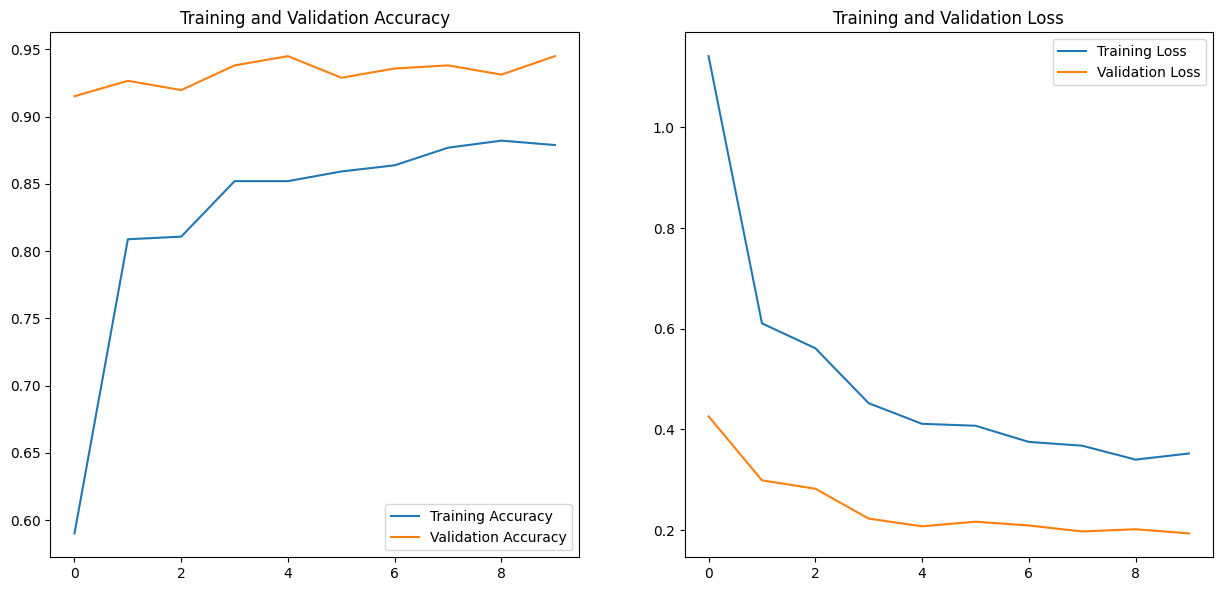

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

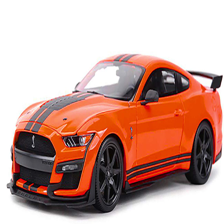

1/1 [==============================] - 2s 2s/step
Predicted label: car


In [70]:
from PIL import Image

img = Image.open('/content/test1.jpg').resize((224, 224))
img.show()

img_array = np.array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)
class_idx = np.argmax(preds)
predicted_class_name = class_names[class_idx]

print('Predicted label:', predicted_class_name)

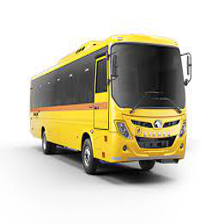

1/1 [==============================] - 0s 36ms/step
Predicted label: bus


In [71]:
from PIL import Image

img = Image.open('/content/test2.jpeg').resize((224, 224))
img.show()

img_array = np.array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)
class_idx = np.argmax(preds)
predicted_class_name = class_names[class_idx]

print('Predicted label:', predicted_class_name)